#### Loading the necessary libraries and packages

In [2]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from tensorflow.keras.utils import Sequence
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous libraries
import numpy as np
import os
import matplotlib.pylab as plt
import gc

#### Define paths

In [3]:
train_image_path = os.path.join('/home', 'renat_sergazinov', 
                                'python-git-workspace', 'PhotoForceReconML', 'image_data', 'train')
val_image_path = os.path.join('/home', 'renat_sergazinov', 
                                'python-git-workspace', 'PhotoForceReconML', 'image_data', 'val')
train_label_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'train')
val_label_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'val')
models_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'models')

#### Data preprocessing and augmentation

Load the data from the directory. The data are the images of particles split into subdirectories based on the number of forces acting on the particle. The labels should be loaded from a separate directory. Each label corresponds to two particles. 

The size of all images is adjusted so that all images are 128*128 using nearest neighbor interpolation. Validation split is performed: 20% is set aside for validation. Additionally images are blurred using Gaussian blur with kernel radius = 1.The pixel values are scaled using 1/255 to be in the interval [0,1].

In [2]:
# Define sorter of image names in order by image number (default is alphanumric)
def sorter(item):
    # Since highest marks first, least error = most marks
    radius = float(item[1 : item.find('_')])
    num_img = int(item[item.find('g') + 1 : item.find('j') - 1])
    return (radius, num_img)

In [3]:
# Load the train and validation sets

X_train, X_val = {}, {}
y_train, y_val = {}, {}

for k in range(5):
    i = k + 2
    X_path_train = os.path.join(train_image_path, str(i))
    X_path_val = os.path.join(val_image_path, str(i))
    X_train[i] = [os.path.join(X_path_train, name) for name in sorted(os.listdir(X_path_train), key = sorter)]
    X_val[i] = [os.path.join(X_path_val, name) for name in sorted(os.listdir(X_path_val), key = sorter)]
    y_train[i] = np.load(os.path.join(train_label_path, str(i), 'angles_tang.npy'))
    y_val[i] = np.load(os.path.join(val_label_path, str(i), 'angles_tang.npy'))

In [4]:
# Define class for data generation
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_image_paths = None, labels = None,  
                 batch_size = 32, dim = None, n_channels = 3, rescale = 1, 
                 shuffle=True, save_dir = None, preprocessing_func = None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_image_paths = list_image_paths
        self.n_channels = n_channels
        self.rescale = rescale
        self.shuffle = shuffle
        self.save_dir = save_dir
        self.preprocessing_func = preprocessing_func
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indices)
        
        if self.save_dir is not None:
            for i in range(X.shape[0]):
                path = os.path.join(self.save_dir, 'img' + str(i) + '.jpg')
                plt.imsave(path, np.asarray(X[i, ]), vmin = 0, vmax = 1)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indices = np.arange(len(self.list_image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, indices):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        # Initialisation
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        list_image_paths_batch = [self.list_image_paths[k] for k in indices]
        
        # Get labels
        y = np.array([self.labels[k, :] for k in indices])
        
        # Generate data
        for i, image_path in enumerate(list_image_paths_batch):
            # Load image and transform
            image = Image.open(os.path.join(image_path))
            if self.dim is not None:
                image = image.resize(self.dim, resample = Image.NEAREST)
            image = np.array(image)[:, :, :self.n_channels]
            image = image * self.rescale
            if self.preprocessing_func is not None:
                image = self.preprocessing_func(image)
            # Store sample
            X[i,] = image

        return X, y

In [5]:
# Define gaussian blur class
class GaussBlur:
    def __init__(self, radius):
        self.radius = radius
    def blur(self, image):
        return gaussian_filter(image, sigma = self.radius)

In [6]:
# Apply data generators
gaussblur = GaussBlur(1)
params = {'batch_size': 32, 
          'dim': (128, 128), 
          'n_channels': 3, 
          'rescale': 1 / 255, 
          'shuffle': True, 
          'save_dir': None,
          'preprocessing_func': gaussblur.blur
          }

training_generator = {}
validation_generator = {}

for k in range(5):
    i = k + 2
    training_generator[i] = DataGenerator(X_train[i], y_train[i], **params)
    validation_generator[i] = DataGenerator(X_val[i], y_val[i], **params) 

#### VGG19 Models Building

Convolutional neural networks is defined and compiled in this step.

In [7]:
base_model = {}

# Load VGG19 model to be the base model
for k in range(5):
    i = k + 2
    base_model[i] = applications.VGG19(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(128, 128, 3),
        include_top=False)
    base_model[i].trainable = False

In [8]:
# Define the model
model = {}
for k in range(5):
    i = k + 2
    inputs = Input(shape=(128, 128, 3))
    x = base_model[i](inputs, training = False)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(i, activation='linear')(x)
    model[i] = Model(inputs, outputs)

In [9]:
for k in range(5):
    i = k + 2
    model[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 28,416,066
Trainable params: 8,391,682
Non-trainable params: 20,024,384
_________________________________________

#### VGG19 Model Training

The model is trained using Adam optimizer. The loss is defined to be mean absolute error. Best model selection across training epochs is implemented with model checkpoint tracking the validation loss. Early stopping is set with patience of 30 epochs. 

In [10]:
for k in range(5):
    i = 2 + k
    model[i].compile(optimizer=tf.keras.optimizers.Adam(),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [11]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = dict()
for k in range(5):
    i = k + 2
    model_path = os.path.join(models_path, 'vgg19_angles_tang_'+str(i)+'.h5')
    mc[i] = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [13]:
epochs = 200
history = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history[i] = model[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/200
500/500 [==============================] - ETA: 0s - loss: 0.1128 - mean_absolute_error: 0.1128
Epoch 00001: val_loss improved from inf to 0.09345, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_tang_2.h5
500/500 [==============================] - 42s 84ms/step - loss: 0.1128 - mean_absolute_error: 0.1128 - val_loss: 0.0935 - val_mean_absolute_error: 0.0935
Epoch 2/200
500/500 [==============================] - ETA: 0s - loss: 0.1071 - mean_absolute_error: 0.1071
Epoch 00002: val_loss improved from 0.09345 to 0.08676, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_tang_2.h5
500/500 [==============================] - 43s 85ms/step - loss: 0.1071 - mean_absolute_error: 0.1071 - val_loss: 0.0868 - val_mean_absolute_error: 0.0868
Epoch 3/200
499/500 [============================>.] - ETA: 0s - loss: 0.1003 - mean_absolute_error: 0.1003
Epoch 00003: val_loss

Epoch 24/200
499/500 [============================>.] - ETA: 0s - loss: 0.0865 - mean_absolute_error: 0.0865
Epoch 00024: val_loss did not improve from 0.03648
500/500 [==============================] - 42s 84ms/step - loss: 0.0865 - mean_absolute_error: 0.0865 - val_loss: 0.0572 - val_mean_absolute_error: 0.0572
Epoch 25/200
500/500 [==============================] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.0887
Epoch 00025: val_loss did not improve from 0.03648
500/500 [==============================] - 40s 80ms/step - loss: 0.0887 - mean_absolute_error: 0.0887 - val_loss: 0.0483 - val_mean_absolute_error: 0.0483
Epoch 26/200
499/500 [============================>.] - ETA: 0s - loss: 0.0877 - mean_absolute_error: 0.0877
Epoch 00026: val_loss did not improve from 0.03648
500/500 [==============================] - 41s 81ms/step - loss: 0.0877 - mean_absolute_error: 0.0877 - val_loss: 0.0596 - val_mean_absolute_error: 0.0596
Epoch 27/200
500/500 [==============================] -

Epoch 50/200
499/500 [============================>.] - ETA: 0s - loss: 0.0849 - mean_absolute_error: 0.0849
Epoch 00050: val_loss did not improve from 0.03540
500/500 [==============================] - 41s 81ms/step - loss: 0.0850 - mean_absolute_error: 0.0850 - val_loss: 0.0444 - val_mean_absolute_error: 0.0444
Epoch 51/200
499/500 [============================>.] - ETA: 0s - loss: 0.0846 - mean_absolute_error: 0.0846
Epoch 00051: val_loss did not improve from 0.03540
500/500 [==============================] - 40s 81ms/step - loss: 0.0845 - mean_absolute_error: 0.0845 - val_loss: 0.0588 - val_mean_absolute_error: 0.0588
Epoch 52/200
500/500 [==============================] - ETA: 0s - loss: 0.0852 - mean_absolute_error: 0.0852
Epoch 00052: val_loss did not improve from 0.03540
500/500 [==============================] - 41s 81ms/step - loss: 0.0852 - mean_absolute_error: 0.0852 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377
Epoch 53/200
500/500 [==============================] -

Epoch 16/200
500/500 [==============================] - ETA: 0s - loss: 0.1542 - mean_absolute_error: 0.1542
Epoch 00016: val_loss did not improve from 0.13195
500/500 [==============================] - 41s 81ms/step - loss: 0.1542 - mean_absolute_error: 0.1542 - val_loss: 0.1369 - val_mean_absolute_error: 0.1369
Epoch 17/200
499/500 [============================>.] - ETA: 0s - loss: 0.1526 - mean_absolute_error: 0.1526
Epoch 00017: val_loss did not improve from 0.13195
500/500 [==============================] - 40s 81ms/step - loss: 0.1526 - mean_absolute_error: 0.1526 - val_loss: 0.1400 - val_mean_absolute_error: 0.1400
Epoch 18/200
500/500 [==============================] - ETA: 0s - loss: 0.1532 - mean_absolute_error: 0.1532
Epoch 00018: val_loss did not improve from 0.13195
500/500 [==============================] - 40s 79ms/step - loss: 0.1532 - mean_absolute_error: 0.1532 - val_loss: 0.1465 - val_mean_absolute_error: 0.1465
Epoch 19/200
500/500 [==============================] -

Epoch 21/200
500/500 [==============================] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2192
Epoch 00021: val_loss did not improve from 0.21868
500/500 [==============================] - 41s 82ms/step - loss: 0.2192 - mean_absolute_error: 0.2192 - val_loss: 0.2189 - val_mean_absolute_error: 0.2189
Epoch 22/200
500/500 [==============================] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2192
Epoch 00022: val_loss did not improve from 0.21868
500/500 [==============================] - 41s 81ms/step - loss: 0.2192 - mean_absolute_error: 0.2192 - val_loss: 0.2187 - val_mean_absolute_error: 0.2187
Epoch 23/200
500/500 [==============================] - ETA: 0s - loss: 0.2193 - mean_absolute_error: 0.2193
Epoch 00023: val_loss did not improve from 0.21868
500/500 [==============================] - 40s 79ms/step - loss: 0.2193 - mean_absolute_error: 0.2193 - val_loss: 0.2189 - val_mean_absolute_error: 0.2189
Epoch 24/200
500/500 [==============================] -

Epoch 10/200
500/500 [==============================] - ETA: 0s - loss: 0.2263 - mean_absolute_error: 0.2263
Epoch 00010: val_loss did not improve from 0.21893
500/500 [==============================] - 40s 80ms/step - loss: 0.2263 - mean_absolute_error: 0.2263 - val_loss: 0.2192 - val_mean_absolute_error: 0.2192
Epoch 11/200
500/500 [==============================] - ETA: 0s - loss: 0.2263 - mean_absolute_error: 0.2263
Epoch 00011: val_loss did not improve from 0.21893
500/500 [==============================] - 40s 80ms/step - loss: 0.2263 - mean_absolute_error: 0.2263 - val_loss: 0.2192 - val_mean_absolute_error: 0.2192
Epoch 12/200
499/500 [============================>.] - ETA: 0s - loss: 0.2263 - mean_absolute_error: 0.2263
Epoch 00012: val_loss did not improve from 0.21893
500/500 [==============================] - 40s 80ms/step - loss: 0.2263 - mean_absolute_error: 0.2263 - val_loss: 0.2191 - val_mean_absolute_error: 0.2191
Epoch 13/200
499/500 [============================>.] -

#### VGG19 Model Fine-tuning

In [14]:
for k in range(5):
    i = k + 2
    base_model[i].trainable = True
    model[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 28,416,066
Trainable params: 28,416,066
Non-trainable params: 0
_________________________________________________

In [15]:
for k in range(5):
    i = 2 + k
    model[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-7),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [16]:
epochs = 100
history_ft = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history_ft[i] = model[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 0.0919 - mean_absolute_error: 0.0919
Epoch 00001: val_loss did not improve from 0.03540
500/500 [==============================] - 56s 112ms/step - loss: 0.0919 - mean_absolute_error: 0.0919 - val_loss: 0.0474 - val_mean_absolute_error: 0.0474
Epoch 2/100
500/500 [==============================] - ETA: 0s - loss: 0.0827 - mean_absolute_error: 0.0827
Epoch 00002: val_loss did not improve from 0.03540
500/500 [==============================] - 56s 111ms/step - loss: 0.0827 - mean_absolute_error: 0.0827 - val_loss: 0.0465 - val_mean_absolute_error: 0.0465
Epoch 3/100
500/500 [==============================] - ETA: 0s - loss: 0.0814 - mean_absolute_error: 0.0814
Epoch 00003: val_loss did not improve from 0.03540
500/500 [==============================] - 55s 111ms/step - loss: 0.0814 - mean_absolute_error: 0.0814 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414
Epoch 4/100
500/500 [=============

Epoch 25/100
500/500 [==============================] - ETA: 0s - loss: 0.0520 - mean_absolute_error: 0.0520
Epoch 00025: val_loss did not improve from 0.01762
500/500 [==============================] - 56s 112ms/step - loss: 0.0520 - mean_absolute_error: 0.0520 - val_loss: 0.0190 - val_mean_absolute_error: 0.0190
Epoch 26/100
500/500 [==============================] - ETA: 0s - loss: 0.0516 - mean_absolute_error: 0.0516
Epoch 00026: val_loss did not improve from 0.01762
500/500 [==============================] - 56s 112ms/step - loss: 0.0516 - mean_absolute_error: 0.0516 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 27/100
500/500 [==============================] - ETA: 0s - loss: 0.0516 - mean_absolute_error: 0.0516
Epoch 00027: val_loss did not improve from 0.01762
500/500 [==============================] - 56s 112ms/step - loss: 0.0516 - mean_absolute_error: 0.0516 - val_loss: 0.0225 - val_mean_absolute_error: 0.0225
Epoch 28/100
500/500 [==============================

Epoch 9/100
500/500 [==============================] - ETA: 0s - loss: 0.1160 - mean_absolute_error: 0.1160
Epoch 00009: val_loss did not improve from 0.09145
500/500 [==============================] - 56s 112ms/step - loss: 0.1160 - mean_absolute_error: 0.1160 - val_loss: 0.0918 - val_mean_absolute_error: 0.0918
Epoch 10/100
500/500 [==============================] - ETA: 0s - loss: 0.1114 - mean_absolute_error: 0.1114
Epoch 00010: val_loss improved from 0.09145 to 0.07689, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_tang_3.h5
500/500 [==============================] - 56s 112ms/step - loss: 0.1114 - mean_absolute_error: 0.1114 - val_loss: 0.0769 - val_mean_absolute_error: 0.0769
Epoch 11/100
500/500 [==============================] - ETA: 0s - loss: 0.1076 - mean_absolute_error: 0.1076
Epoch 00011: val_loss did not improve from 0.07689
500/500 [==============================] - 56s 112ms/step - loss: 0.1076 - mean_absolute_error: 

500/500 [==============================] - 56s 113ms/step - loss: 0.0836 - mean_absolute_error: 0.0836 - val_loss: 0.0382 - val_mean_absolute_error: 0.0382
Epoch 33/100
500/500 [==============================] - ETA: 0s - loss: 0.0826 - mean_absolute_error: 0.0826
Epoch 00033: val_loss did not improve from 0.03825
500/500 [==============================] - 56s 111ms/step - loss: 0.0826 - mean_absolute_error: 0.0826 - val_loss: 0.0531 - val_mean_absolute_error: 0.0531
Epoch 34/100
500/500 [==============================] - ETA: 0s - loss: 0.0823 - mean_absolute_error: 0.0823
Epoch 00034: val_loss did not improve from 0.03825
500/500 [==============================] - 56s 112ms/step - loss: 0.0823 - mean_absolute_error: 0.0823 - val_loss: 0.0492 - val_mean_absolute_error: 0.0492
Epoch 35/100
500/500 [==============================] - ETA: 0s - loss: 0.0815 - mean_absolute_error: 0.0815
Epoch 00035: val_loss did not improve from 0.03825
500/500 [==============================] - 56s 111ms

Epoch 32/100
500/500 [==============================] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2192
Epoch 00032: val_loss did not improve from 0.21868
500/500 [==============================] - 56s 111ms/step - loss: 0.2192 - mean_absolute_error: 0.2192 - val_loss: 0.2189 - val_mean_absolute_error: 0.2189
Epoch 33/100
500/500 [==============================] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2192
Epoch 00033: val_loss did not improve from 0.21868
500/500 [==============================] - 56s 112ms/step - loss: 0.2192 - mean_absolute_error: 0.2192 - val_loss: 0.2189 - val_mean_absolute_error: 0.2189
Epoch 34/100
500/500 [==============================] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2192
Epoch 00034: val_loss did not improve from 0.21868
500/500 [==============================] - 56s 111ms/step - loss: 0.2192 - mean_absolute_error: 0.2192 - val_loss: 0.2189 - val_mean_absolute_error: 0.2189
Epoch 35/100
500/500 [==============================

Epoch 58/100
500/500 [==============================] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2192
Epoch 00058: val_loss did not improve from 0.21868
500/500 [==============================] - 56s 112ms/step - loss: 0.2192 - mean_absolute_error: 0.2192 - val_loss: 0.2189 - val_mean_absolute_error: 0.2189
Epoch 59/100
500/500 [==============================] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2192
Epoch 00059: val_loss did not improve from 0.21868
500/500 [==============================] - 56s 112ms/step - loss: 0.2192 - mean_absolute_error: 0.2192 - val_loss: 0.2189 - val_mean_absolute_error: 0.2189
Epoch 60/100
500/500 [==============================] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2192
Epoch 00060: val_loss did not improve from 0.21868
500/500 [==============================] - 56s 112ms/step - loss: 0.2192 - mean_absolute_error: 0.2192 - val_loss: 0.2189 - val_mean_absolute_error: 0.2189
Epoch 61/100
500/500 [==============================

Epoch 84/100
500/500 [==============================] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2192
Epoch 00084: val_loss did not improve from 0.21868
500/500 [==============================] - 56s 111ms/step - loss: 0.2192 - mean_absolute_error: 0.2192 - val_loss: 0.2189 - val_mean_absolute_error: 0.2189
Epoch 85/100
500/500 [==============================] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2192
Epoch 00085: val_loss did not improve from 0.21868
500/500 [==============================] - 56s 112ms/step - loss: 0.2192 - mean_absolute_error: 0.2192 - val_loss: 0.2189 - val_mean_absolute_error: 0.2189
Epoch 86/100
500/500 [==============================] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2192
Epoch 00086: val_loss did not improve from 0.21868
500/500 [==============================] - 56s 112ms/step - loss: 0.2192 - mean_absolute_error: 0.2192 - val_loss: 0.2189 - val_mean_absolute_error: 0.2189
Epoch 87/100
500/500 [==============================

Epoch 20/100
500/500 [==============================] - ETA: 0s - loss: 0.2262 - mean_absolute_error: 0.2262
Epoch 00020: val_loss did not improve from 0.21893
500/500 [==============================] - 56s 111ms/step - loss: 0.2262 - mean_absolute_error: 0.2262 - val_loss: 0.2191 - val_mean_absolute_error: 0.2191
Epoch 21/100
500/500 [==============================] - ETA: 0s - loss: 0.2262 - mean_absolute_error: 0.2262
Epoch 00021: val_loss did not improve from 0.21893
500/500 [==============================] - 56s 112ms/step - loss: 0.2262 - mean_absolute_error: 0.2262 - val_loss: 0.2191 - val_mean_absolute_error: 0.2191
Epoch 22/100
500/500 [==============================] - ETA: 0s - loss: 0.2262 - mean_absolute_error: 0.2262
Epoch 00022: val_loss did not improve from 0.21893
500/500 [==============================] - 56s 111ms/step - loss: 0.2262 - mean_absolute_error: 0.2262 - val_loss: 0.2191 - val_mean_absolute_error: 0.2191
Epoch 23/100
500/500 [==============================

Epoch 13/100
500/500 [==============================] - ETA: 0s - loss: 0.2225 - mean_absolute_error: 0.2225
Epoch 00013: val_loss did not improve from 0.22604
500/500 [==============================] - 56s 112ms/step - loss: 0.2225 - mean_absolute_error: 0.2225 - val_loss: 0.2270 - val_mean_absolute_error: 0.2270
Epoch 14/100
500/500 [==============================] - ETA: 0s - loss: 0.2225 - mean_absolute_error: 0.2225
Epoch 00014: val_loss did not improve from 0.22604
500/500 [==============================] - 56s 112ms/step - loss: 0.2225 - mean_absolute_error: 0.2225 - val_loss: 0.2270 - val_mean_absolute_error: 0.2270
Epoch 15/100
500/500 [==============================] - ETA: 0s - loss: 0.2225 - mean_absolute_error: 0.2225
Epoch 00015: val_loss did not improve from 0.22604
500/500 [==============================] - 55s 111ms/step - loss: 0.2225 - mean_absolute_error: 0.2225 - val_loss: 0.2270 - val_mean_absolute_error: 0.2270
Epoch 16/100
500/500 [==============================

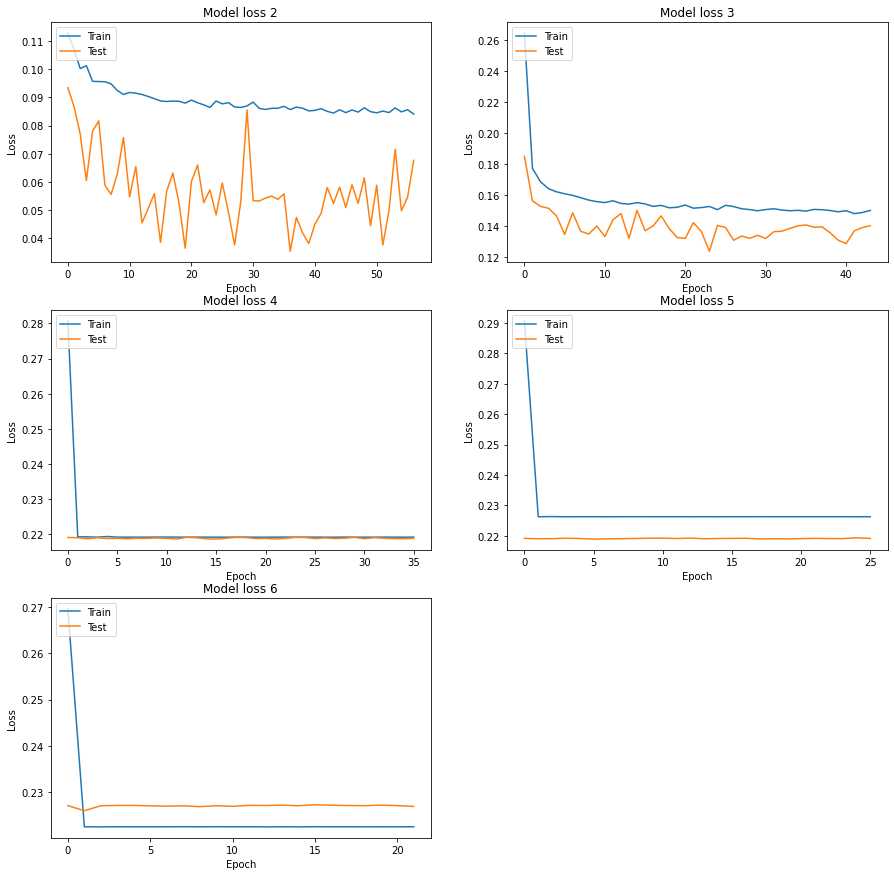

In [17]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history[i+2].history['loss'])
    plt.plot(history[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

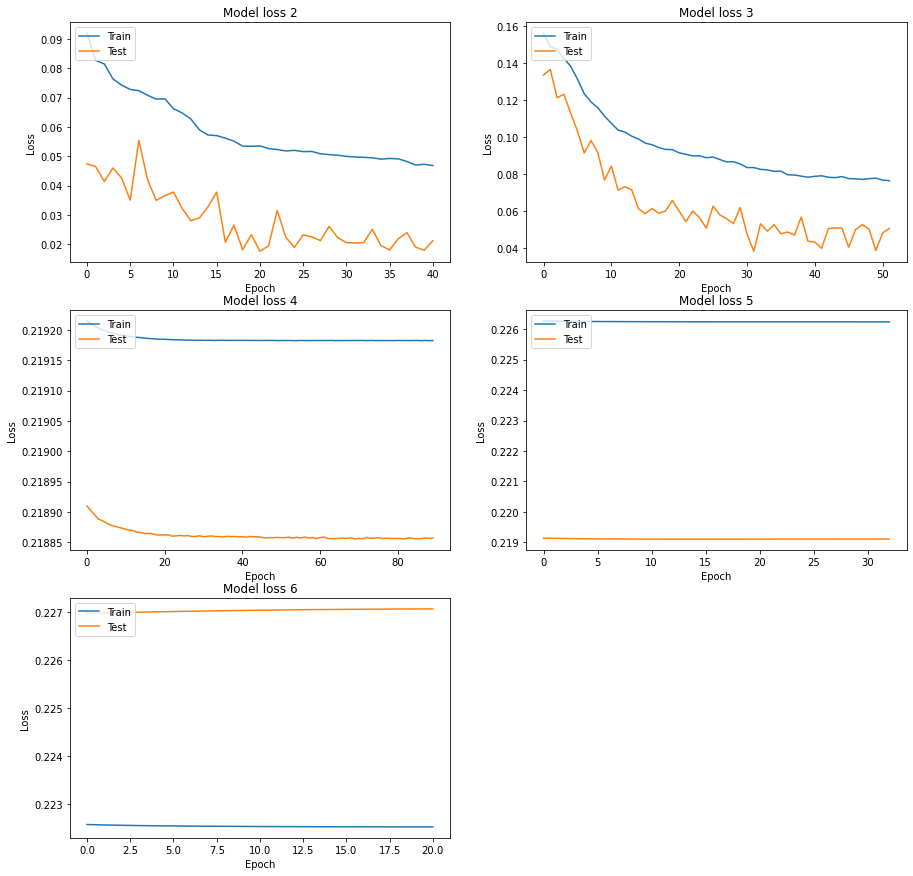

In [18]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history_ft[i+2].history['loss'])
    plt.plot(history_ft[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')